In [ ]:
!unzip -q /content/2017_English_final.zip

In [ ]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GRU, LSTM, Bidirectional, MaxPooling1D
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

import re
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


### LOAD DATASET AND BASIC INSIGHTS

In [ ]:
# List of GOLD files for training (2013–2016)
training_file_paths = [
    "2017_English_final/GOLD/Subtask_A/twitter-2013train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2013dev-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2013test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2014sarcasm-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2014test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2015train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2015test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016devtest-A.txt"]

In [ ]:
# GOLD file for final test set (2016 test)
test_file_path = "2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

In [ ]:
# Load and concatenate all training parts
train_dfs = []
for path in training_file_paths:
    df_temp = pd.read_csv(path,
        sep="\t",header=None,names=["id", "label", "tweet", "extra"],
        quoting=3,encoding="utf-8")
    train_dfs.append(df_temp)

train_df = pd.concat(train_dfs, ignore_index=True)

In [ ]:
# Load test set
test_df = pd.read_csv(test_file_path,sep="\t",header=None,names=["id", "label", "tweet", "extra"],quoting=3,encoding="utf-8")

In [ ]:
# Keep only label and tweet columns
train_df = train_df[["label", "tweet"]]
test_df = test_df[["label", "tweet"]]

In [ ]:
print("Training data - first 5 rows:")
train_df.head()

Training data - first 5 rows:


,label,tweet
0,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,negative,Iranian general says Israel\u2019s Iron Dome c...
4,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [ ]:
print("Training data shape (rows, columns):")
print(train_df.shape)

Training data shape (rows, columns):
(29702, 2)


In [ ]:
print("Training label distribution:")
print(train_df["label"].value_counts())

Training label distribution:
label
positive    12844
neutral     12249
negative     4609
Name: count, dtype: int64


In [ ]:
print("Test data - first 5 rows:")
test_df.head()

Test data - first 5 rows:


,label,tweet
0,neutral,"""Picturehouse's, Pink Floyd's, 'Roger Waters: ..."
1,neutral,Order Go Set a Watchman in store or through ou...
2,negative,"""If these runway renovations at the airport pr..."
3,neutral,"""If you could ask an onstage interview questio..."
4,positive,A portion of book sales from our Harper Lee/Go...


In [ ]:
print("Test data shape (rows, columns):")
print(test_df.shape)

Test data shape (rows, columns):
(20633, 2)


In [ ]:
print("Test label distribution:")
print(test_df["label"].value_counts())

Test label distribution:
label
neutral     10342
positive     7059
negative     3231
Name: count, dtype: int64


* BASIC CLEANING: HANDLE NULLS, STRIP, LENGTHS

In [ ]:
# Drop rows with missing label or tweet
train_df = train_df.dropna(subset=["tweet", "label"])
test_df = test_df.dropna(subset=["tweet", "label"])

In [ ]:
# Ensure tweet is string
train_df["tweet"] = train_df["tweet"].astype(str)
test_df["tweet"] = test_df["tweet"].astype(str)

In [ ]:
# Strip whitespace
train_df["tweet"] = train_df["tweet"].str.strip()
test_df["tweet"] = test_df["tweet"].str.strip()

In [ ]:
# Tweet length (characters) for EDA
train_df["tweet_length"] = train_df["tweet"].str.len()
test_df["tweet_length"] = test_df["tweet"].str.len()

print("\nTraining data after cleaning, shape:", train_df.shape)
print("Test data after cleaning, shape:", test_df.shape)


Training data after cleaning, shape: (29702, 3)
Test data after cleaning, shape: (20632, 3)


### EDA

In [ ]:
sns.set(style="whitegrid")

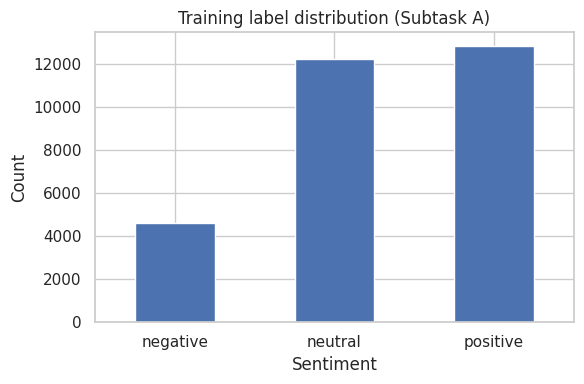

In [ ]:
# Training label distribution
plt.figure(figsize=(6, 4))
train_df["label"].value_counts().reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Training label distribution (Subtask A)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

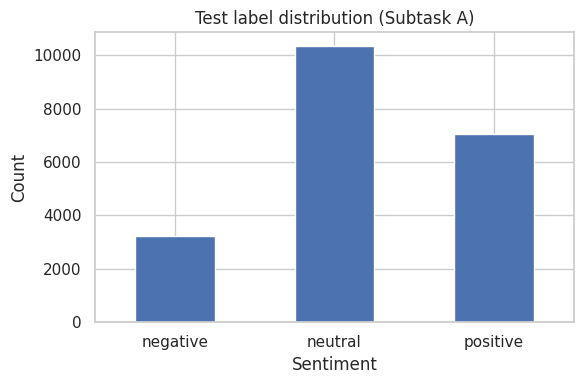

In [ ]:
# Test label distribution
plt.figure(figsize=(6, 4))
test_df["label"].value_counts().reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Test label distribution (Subtask A)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

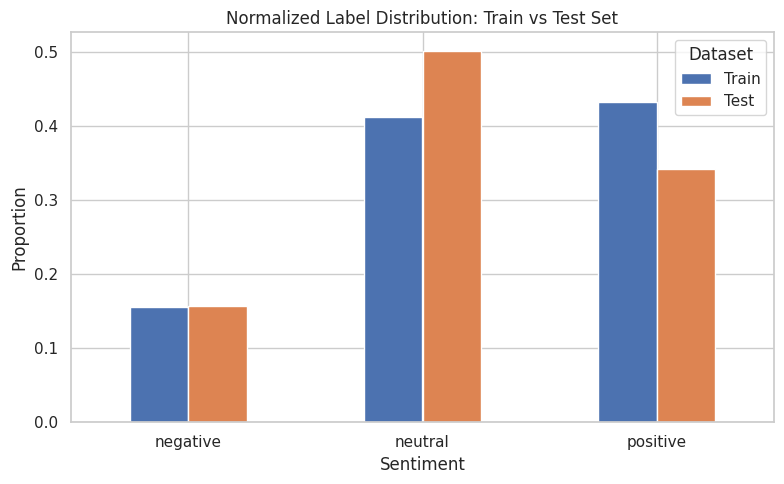

In [ ]:
# Stacked bar chart of label distribution in training vs test data
train_label_counts = train_df["label"].value_counts(normalize=True).reindex(["negative", "neutral", "positive"])
test_label_counts = test_df["label"].value_counts(normalize=True).reindex(["negative", "neutral", "positive"])
combined_labels = pd.DataFrame({'Train': train_label_counts, 'Test': test_label_counts})
combined_labels.plot(kind='bar', stacked=False, figsize=(8, 5))
plt.title('Normalized Label Distribution: Train vs Test Set')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

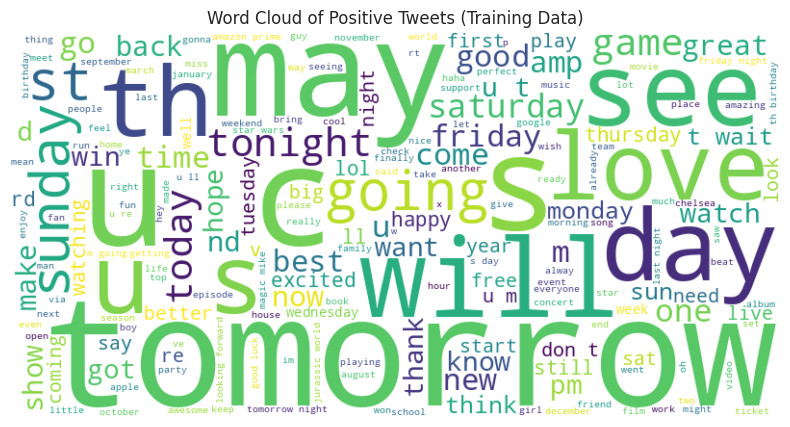

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Join all positive tweets into one string
positive_tweets = " ".join(train_df[train_df["label"] == "positive"]["clean_tweet"].dropna().tolist())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(positive_tweets)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Tweets (Training Data)")
plt.show()

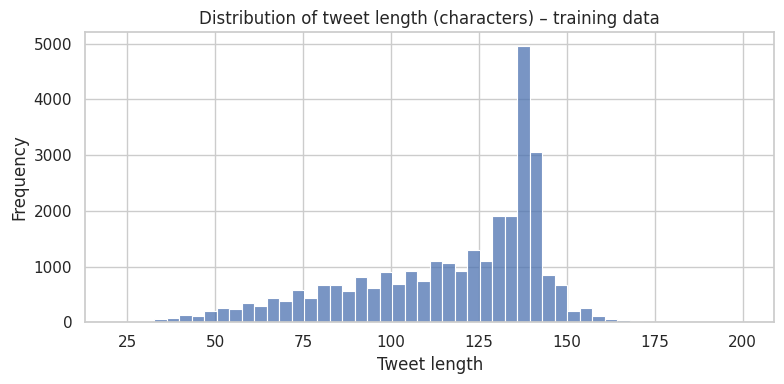

In [ ]:
# Distribution of tweet length (characters) in training data
plt.figure(figsize=(8, 4))
sns.histplot(train_df["tweet_length"], bins=50, kde=False)
plt.title("Distribution of tweet length (characters) – training data")
plt.xlabel("Tweet length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

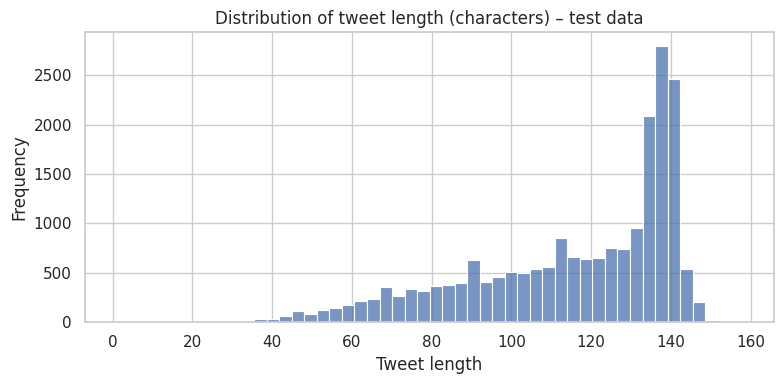

In [ ]:
# Distribution of tweet length (characters) in test data
plt.figure(figsize=(8, 4))
sns.histplot(test_df["tweet_length"], bins=50, kde=False)
plt.title("Distribution of tweet length (characters) – test data")
plt.xlabel("Tweet length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

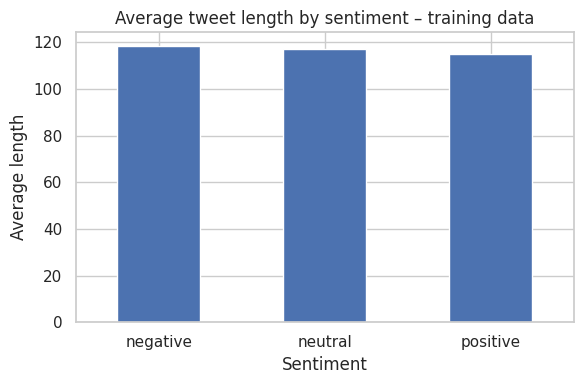

In [ ]:
# Average tweet length by sentiment
mean_lengths = train_df.groupby("label")["tweet_length"].mean()
plt.figure(figsize=(6, 4))
mean_lengths.reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Average tweet length by sentiment – training data")
plt.xlabel("Sentiment")
plt.ylabel("Average length")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### TEXT PREPROCESSING FOR RNN/CNN MODELS (CLEAN TWEETS)

In [ ]:
# Copy original tweets
train_clean = train_df["tweet"].str.lower()
test_clean = test_df["tweet"].str.lower()

In [ ]:
# Remove URLs
train_clean = train_clean.str.replace(r"http\S+|www\S+|https\S+", " ", regex=True)
test_clean = test_clean.str.replace(r"http\S+|www\S+|https\S+", " ", regex=True)

In [ ]:
# Remove @mentions
train_clean = train_clean.str.replace(r"@\w+", " ", regex=True)
test_clean = test_clean.str.replace(r"@\w+", " ", regex=True)

In [ ]:
# Remove hashtag symbol but keep text
train_clean = train_clean.str.replace("#", " ", regex=True)
test_clean = test_clean.str.replace("#", " ", regex=True)

In [ ]:
# Remove non-letter characters
train_clean = train_clean.str.replace(r"[^a-z\s]", " ", regex=True)
test_clean = test_clean.str.replace(r"[^a-z\s]", " ", regex=True)

In [ ]:
# Remove extra spaces
train_clean = train_clean.str.replace(r"\s+", " ", regex=True)
test_clean = test_clean.str.replace(r"\s+", " ", regex=True)

In [ ]:
# Strip again
train_clean = train_clean.str.strip()
test_clean = test_clean.str.strip()

In [ ]:
# Attach cleaned text
train_df["clean_tweet"] = train_clean
test_df["clean_tweet"] = test_clean

print("Original vs cleaned tweets (sample):")
train_df[["tweet", "clean_tweet"]].head()

Original vs cleaned tweets (sample):


,tweet,clean_tweet
0,Gas by my house hit $3.39!!!! I\u2019m going t...,gas by my house hit i u m going to chapel hill...
1,Theo Walcott is still shit\u002c watch Rafa an...,theo walcott is still shit u c watch rafa and ...
2,its not that I\u2019m a GSP fan\u002c i just h...,its not that i u m a gsp fan u c i just hate n...
3,Iranian general says Israel\u2019s Iron Dome c...,iranian general says israel u s iron dome can ...
4,Tehran\u002c Mon Amour: Obama Tried to Establi...,tehran u c mon amour obama tried to establish ...


In [ ]:
# LABEL ENCODING FOR ALL DL MODELS
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
inverse_label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

y_train = train_df["label"].map(label_mapping).astype(int).values
y_test = test_df["label"].map(label_mapping).astype(int).values

print("\nLabel mapping:", label_mapping)
print("Training label sample:", y_train[:10])


Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Training label sample: [2 0 0 0 1 1 2 0 1 0]


* TOKENIZATION & PADDING FOR GRU AND CNN+BiLSTM MODELS

In [ ]:
max_words = 30000   # vocabulary size
max_length = 40     # max tweet length in tokens
embedding_dim = 128

In [ ]:
# cleaned text for RNN/CNN models
rnn_train_texts = train_df["clean_tweet"]
rnn_test_texts = test_df["clean_tweet"]

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(rnn_train_texts)

X_train_seq = tokenizer.texts_to_sequences(rnn_train_texts)
X_test_seq = tokenizer.texts_to_sequences(rnn_test_texts)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

print("\nPadded sequence shape – train:", X_train_padded.shape)
print("Padded sequence shape – test:", X_test_padded.shape)


Padded sequence shape – train: (29702, 40)
Padded sequence shape – test: (20632, 40)


In [ ]:
# 1) GRU-BASED MODEL
gru_model = Sequential()
gru_model.add(Embedding(input_dim=30000, output_dim=128, input_length=max_length))
gru_model.add(GRU(128))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(64, activation="relu"))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(3, activation="softmax"))

In [ ]:
# Compile Model
gru_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [ ]:
print("\nGRU model summary:")
gru_model.build(input_shape=(None, max_length))
gru_model.summary()


GRU model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,947,523 (15.06 MB)

 Trainable params: 3,947,523 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model
gru_history = gru_model.fit(X_train_padded, y_train,
                            epochs=15, batch_size=64,
                            validation_split=0.1, verbose=1)

Epoch 1/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4182 - loss: 1.0328 - val_accuracy: 0.4662 - val_loss: 1.0404
Epoch 2/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4383 - loss: 1.0137 - val_accuracy: 0.4837 - val_loss: 0.9728
Epoch 3/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6613 - loss: 0.7743 - val_accuracy: 0.5284 - val_loss: 0.9421
Epoch 4/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7964 - loss: 0.5141 - val_accuracy: 0.5332 - val_loss: 1.0581
Epoch 5/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8832 - loss: 0.3189 - val_accuracy: 0.5247 - val_loss: 1.3176
Epoch 6/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9348 - loss: 0.1916 - val_accuracy: 0.5241 - val_loss: 1.7269
Epoch 7/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9577 - loss: 0.1207 - val_accuracy: 0.5173 - val_loss: 2.2515
Epoch 8/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9714 - loss: 0.0841 - val_accuracy: 

In [ ]:
gru_preds = np.argmax(gru_model.predict(X_test_padded), axis=1)
gru_acc = accuracy_score(y_test, gru_preds)
gru_f1 = f1_score(y_test, gru_preds, average="macro")

645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
print("GRU Test Accuracy:", gru_acc)
print("GRU Macro F1:", gru_f1)

GRU Test Accuracy: 0.545317952694843
GRU Macro F1: 0.5209320749804268


In [ ]:
gru_true_labels = pd.Series(y_test).map(inverse_label_mapping)
gru_pred_labels = pd.Series(gru_preds).map(inverse_label_mapping)

In [ ]:
print("GRU Classification Report:")
print(classification_report(gru_true_labels, gru_pred_labels,target_names=["negative", "neutral", "positive"]))

GRU Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.45      0.42      3231
     neutral       0.61      0.53      0.57     10342
    positive       0.55      0.60      0.57      7059

    accuracy                           0.55     20632
   macro avg       0.52      0.53      0.52     20632
weighted avg       0.55      0.55      0.55     20632



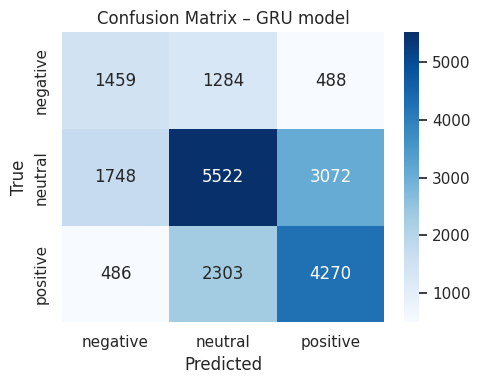

In [ ]:
gru_cm = confusion_matrix(gru_true_labels, gru_pred_labels,labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(gru_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – GRU model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

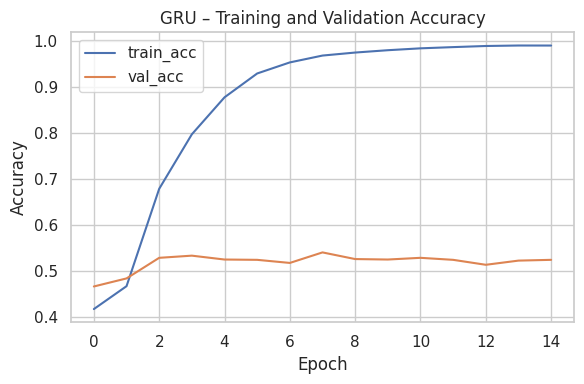

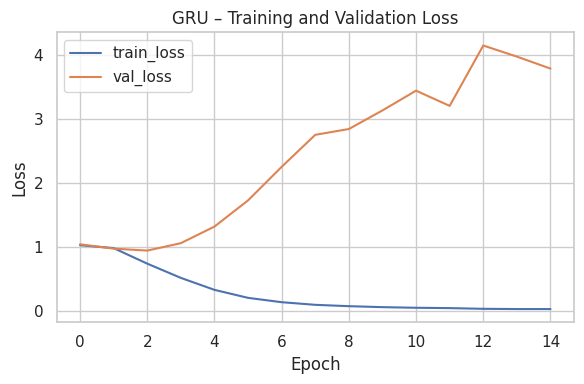

In [ ]:
# Plot GRU training history
plt.figure(figsize=(6, 4))
plt.plot(gru_history.history["accuracy"], label="train_acc")
plt.plot(gru_history.history["val_accuracy"], label="val_acc")
plt.title("GRU – Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(gru_history.history["loss"], label="train_loss")
plt.plot(gru_history.history["val_loss"], label="val_loss")
plt.title("GRU – Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 2) CNN + BiLSTM HYBRID MODEL
cnn_bilstm_model = Sequential()
cnn_bilstm_model.add(Embedding(input_dim=30000, output_dim=128, input_length=max_length))
cnn_bilstm_model.add(Conv1D(128, 5, activation="relu"))
cnn_bilstm_model.add(MaxPooling1D(2))
cnn_bilstm_model.add(Bidirectional(LSTM(128)))
cnn_bilstm_model.add(Dropout(0.5))
cnn_bilstm_model.add(Dense(64, activation="relu"))
cnn_bilstm_model.add(Dropout(0.5))
cnn_bilstm_model.add(Dense(3, activation="softmax"))

In [ ]:
# Compile Model
cnn_bilstm_model.compile(loss="sparse_categorical_crossentropy",
                         optimizer="adam",
                         metrics=["accuracy"])

In [ ]:
print("CNN + BiLSTM model summary:")
cnn_bilstm_model.build(input_shape=(None, max_length))
cnn_bilstm_model.summary()

CNN + BiLSTM model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 36, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,201,859 (16.03 MB)

 Trainable params: 4,201,859 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
cnn_bilstm_history = cnn_bilstm_model.fit(X_train_padded, y_train,
                                          epochs=15, batch_size=64,
                                          validation_split=0.1, verbose=1)

Epoch 1/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4927 - loss: 0.9654 - val_accuracy: 0.4978 - val_loss: 0.9592
Epoch 2/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7539 - loss: 0.6020 - val_accuracy: 0.5143 - val_loss: 0.9878
Epoch 3/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8677 - loss: 0.3619 - val_accuracy: 0.5301 - val_loss: 1.3067
Epoch 4/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9377 - loss: 0.1860 - val_accuracy: 0.5422 - val_loss: 1.4049
Epoch 5/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9666 - loss: 0.1050 - val_accuracy: 0.5150 - val_loss: 1.9258
Epoch 6/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9796 - loss: 0.0706 - val_accuracy: 0.5271 - val_loss: 2.0417
Epoch 7/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9875 - loss: 0.0483 - val_accuracy: 0.5116 - val_loss: 2.9188
Epoch 8/15
418/418 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9934 - loss: 0.0290 - val_ac

In [ ]:
cnn_preds = np.argmax(cnn_bilstm_model.predict(X_test_padded), axis=1)
cnn_acc = accuracy_score(y_test, cnn_preds)
cnn_f1 = f1_score(y_test, cnn_preds, average="macro")

645/645 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
print("CNN + BiLSTM Test Accuracy:", cnn_acc)
print("CNN + BiLSTM Macro F1:", cnn_f1)

CNN + BiLSTM Test Accuracy: 0.5617002714230321
CNN + BiLSTM Macro F1: 0.521045506870491


In [ ]:
cnn_bilstm_true_labels = pd.Series(y_test).map(inverse_label_mapping)
cnn_bilstm_pred_labels = pd.Series(cnn_preds).map(inverse_label_mapping)

In [ ]:
# Classification report
print("CNN + BiLSTM Classification Report:")
print(classification_report(cnn_bilstm_true_labels, cnn_bilstm_pred_labels,
                            target_names=["negative", "neutral", "positive"]))

CNN + BiLSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.43      0.35      0.39      3231
     neutral       0.61      0.60      0.61     10342
    positive       0.54      0.60      0.57      7059

    accuracy                           0.56     20632
   macro avg       0.53      0.52      0.52     20632
weighted avg       0.56      0.56      0.56     20632



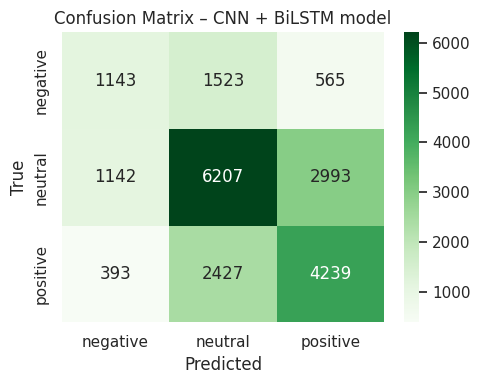

In [ ]:
cnn_bilstm_cm = confusion_matrix(cnn_bilstm_true_labels, cnn_bilstm_pred_labels,labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(cnn_bilstm_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – CNN + BiLSTM model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

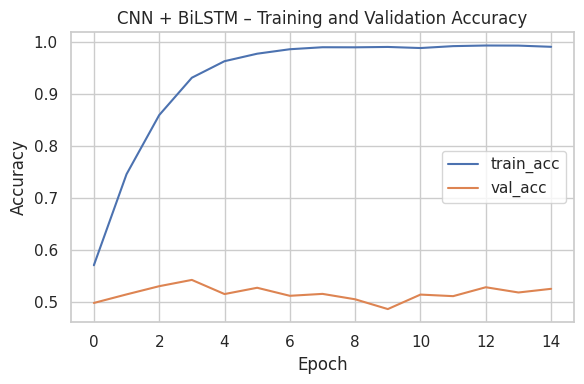

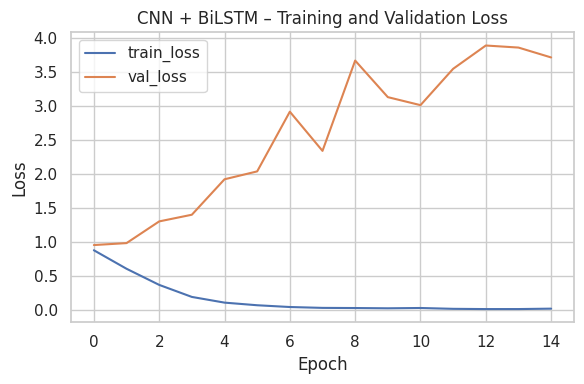

In [ ]:
# Plot CNN+BiLSTM training history (accuracy & loss)
plt.figure(figsize=(6, 4))
plt.plot(cnn_bilstm_history.history["accuracy"], label="train_acc")
plt.plot(cnn_bilstm_history.history["val_accuracy"], label="val_acc")
plt.title("CNN + BiLSTM – Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(cnn_bilstm_history.history["loss"], label="train_loss")
plt.plot(cnn_bilstm_history.history["val_loss"], label="val_loss")
plt.title("CNN + BiLSTM – Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# COMPARISON OF MODELS (GRU vs CNN+BiLSTM )
model_accuracies = {"GRU": gru_acc,"CNN + BiLSTM": cnn_acc}
model_macro_f1 = {"GRU": gru_f1,"CNN + BiLSTM": cnn_f1}
accuracy_df = pd.DataFrame({"Model": list(model_accuracies.keys()),"Accuracy": list(model_accuracies.values()),"Macro_F1": list(model_macro_f1.values())})

print("Model performance summary:")
accuracy_df

Model performance summary:


,Model,Accuracy,Macro_F1
0,GRU,0.545318,0.520932
1,CNN + BiLSTM,0.561700,0.521046


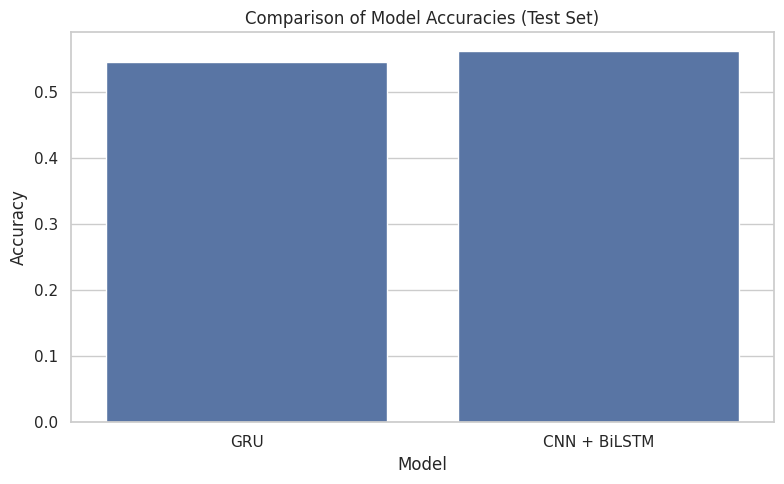

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df)
plt.title("Comparison of Model Accuracies (Test Set)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

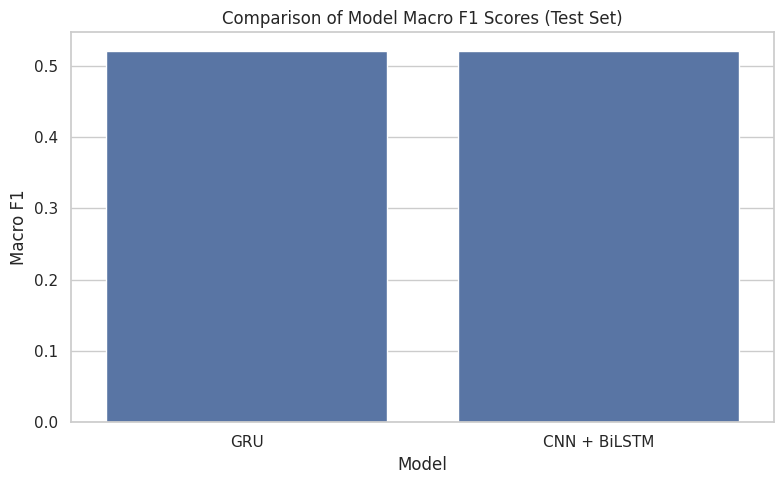

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Macro_F1", data=accuracy_df)
plt.title("Comparison of Model Macro F1 Scores (Test Set)")
plt.xlabel("Model")
plt.ylabel("Macro F1")
plt.tight_layout()
plt.show()